# Compile and Train a Hugging Face Transformer BERT Model with the SST Dataset using SageMaker Training Compiler

1. [Overview](#Overview)
2. [Introduction](#Introduction)  
3. [Prepare SageMaker Environment and Permissions](#Prepare-SageMaker-Environment-and-Permissions)
    1. [Install libraries](#Install-libraries)  
    2. [SageMaker environment](#SageMaker-environment)  
    3. [Permissions](#Permissions)
4. [Loading a dataset](#Loading-a-dataset)   
    1. [Tokenization](#Tokenization)  
    2. [Uploading data to SageMaker_session_bucket](#Uploading-data-to-sagemaker_session_bucket)  
5. [SageMaker Training Job](#Sagemaker-Training-Job)  
    1. [Training a PyTorch Trainer without compiling](#Training-a-PyTorch-Trainer-without-compiling)  
    2. [Training a PyTorch Trainer with SageMaker Training Compiler](#Training-a-PyTorch-Trainer-with-SageMaker-Training-Compiler) 
6. [Analysis and Results](#Analysis-and-Results)  

## SageMaker Training Compiler Overview

SageMaker Training Compiler is a capability of SageMaker that makes these hard-to-implement optimizations to reduce training time on GPU instances. The compiler optimizes DL models to accelerate training by more efficiently using SageMaker machine learning (ML) GPU instances. SageMaker Training Compiler is available at no additional charge within SageMaker and can help reduce total billable time as it accelerates training. 

SageMaker Training Compiler is integrated into the AWS Deep Learning Containers (DLCs). Using the SageMaker Training Compiler enabled AWS DLCs, you can compile and optimize training jobs on GPU instances with minimal changes to your code. Bring your deep learning models to SageMaker and enable SageMaker Training Compiler to accelerate the speed of your training job on SageMaker ML instances for accelerated computing. 

For more information, see [SageMaker Training Compiler](https://docs.aws.amazon.com/sagemaker/latest/dg/training-compiler.html) in the *Amazon SageMaker Developer Guide*.

## Introduction

This notebook is an end-to-end binary text classification example. In this demo, we use the Hugging Face's transformers and datasets libraries with SageMaker Training Compiler to compile and fine-tune a pre-trained transformer for binary text classification. In particular, the pre-trained model will be fine-tuned using the Stanford Sentiment Treebank (SST) dataset. To get started, you need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on. 

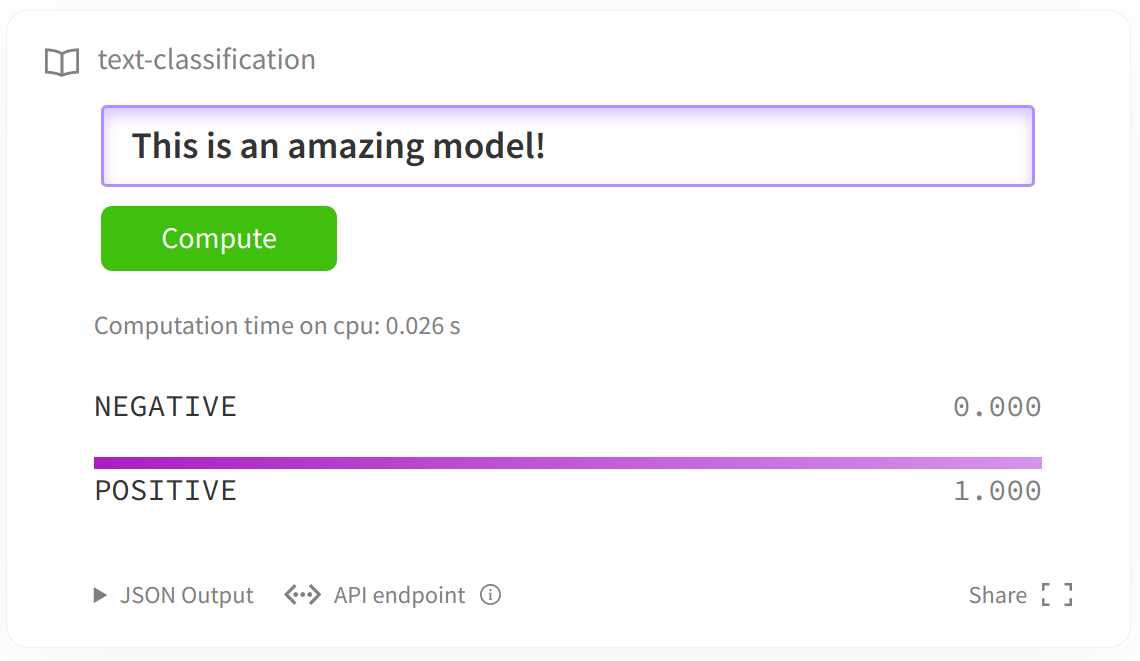

**NOTE:** You can run this demo in SageMaker Studio, SageMaker notebook instances, or your local machine with AWS CLI set up. If using SageMaker Studio or SageMaker notebook instances, make sure you choose one of the PyTorch-based kernels, Python 3 (PyTorch x.y Python 3.x CPU Optimized) or conda_pytorch_p36 respectively.

**NOTE:** This notebook uses two ml.p3.2xlarge instances that have single GPU. If you don't have enough quota, see [Request a service quota increase for SageMaker resources](https://docs.aws.amazon.com/sagemaker/latest/dg/regions-quotas.html#service-limit-increase-request-procedure). 

## Prepare SageMaker Environment and Permissions 

### Installation

This example notebook requires the **SageMaker Python SDK v2.108.0** and **transformers v4.21**.

In [ ]:
!pip install "sagemaker>=2.108.0" botocore boto3 awscli s3fs typing-extensions "torch==1.11.0" --upgrade

In [ ]:
!pip install "transformers==4.21" datasets --upgrade

In [ ]:
import botocore
import boto3
import sagemaker
import transformers

print(f"sagemaker: {sagemaker.__version__}")
print(f"transformers: {transformers.__version__}")

Copy and run the following code if you need to upgrade ipywidgets for datasets library and restart kernel. This is only needed when preprocessing is done in the notebook.

```python
%%capture
import IPython
!conda install -c conda-forge ipywidgets -y
# has to restart kernel for the updates to be applied
IPython.Application.instance().kernel.do_shutdown(True) 
```

### SageMaker environment 

**Note:** If you are going to use SageMaker in a local environment. You need access to an IAM Role with the required permissions for SageMaker. To learn more, see [SageMaker Roles](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html).

In [ ]:
import sagemaker

sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket = None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

role = sagemaker.get_execution_role()
sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

## Loading the SST dataset

When using the [🤗 Datasets library](https://github.com/huggingface/datasets), datasets can be downloaded directly with the following `datasets.load_dataset()` method:

```python
from datasets import load_dataset
load_dataset('dataset_name')
```

If you'd like to try other training datasets later, you can simply use this method.

For this example notebook, we prepared the [SST2 dataset](https://www.tensorflow.org/datasets/catalog/glue#gluesst2) in the public SageMaker sample S3 bucket. The following code cells show how you can directly load the dataset and convert to a HuggingFace DatasetDict.

### Tokenization 

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer
from datasets import Dataset

# tokenizer used in preprocessing
tokenizer_name = "bert-base-cased"

# dataset used
dataset_name = "sst"

In [ ]:
import pandas as pd

# Read our data into pandas DataFrames to prepare it for training
# Initially our dataset will contain one column called 'line'

test_df = pd.read_csv(
    "https://sagemaker-sample-files.s3.amazonaws.com/datasets/text/SST2/sst2.test",
    sep="delimiter",
    header=None,
    engine="python",
    names=["line"],
)
train_df = pd.read_csv(
    "https://sagemaker-sample-files.s3.amazonaws.com/datasets/text/SST2/sst2.train",
    sep="delimiter",
    header=None,
    engine="python",
    names=["line"],
)
val_df = pd.read_csv(
    "https://sagemaker-sample-files.s3.amazonaws.com/datasets/text/SST2/sst2.val",
    sep="delimiter",
    header=None,
    engine="python",
    names=["line"],
)

In [ ]:
# Split each row into two columns one for the label and one for the text

test_df[["label", "text"]] = test_df["line"].str.split(" ", 1, expand=True)
train_df[["label", "text"]] = train_df["line"].str.split(" ", 1, expand=True)
val_df[["label", "text"]] = val_df["line"].str.split(" ", 1, expand=True)

In [ ]:
# Drop the line column as it is no longer needed since we split this column above

test_df.drop("line", axis=1, inplace=True)
train_df.drop("line", axis=1, inplace=True)
val_df.drop("line", axis=1, inplace=True)

In [ ]:
# Convert the label into numeric instead of object type to prepare binary labels for training
# After conversion the labels will be 8 bit integers

test_df["label"] = pd.to_numeric(test_df["label"], downcast="integer")
train_df["label"] = pd.to_numeric(train_df["label"], downcast="integer")
val_df["label"] = pd.to_numeric(val_df["label"], downcast="integer")

In [ ]:
# Combine test and val data into one df

test_df = pd.concat([test_df, val_df], ignore_index=True)

In [ ]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [ ]:
# Download tokenizer
# The tokenizer is loaded from the AutoTokenizer class and we use the from_pretrained method
# This allows us to instatiate a tokenizer based on a pretrained model
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

# Tokenizer helper function
# This function specifies the input should be tokenized by padding to the max_length which is 512
# Anything beyond this length will be truncated
# This function will convert the 'text' column to a set of numeric input ids that can be used for
# model training
# For more information on tokenization see the Hugging Face documentation: https://huggingface.co/transformers/preprocessing.html
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True)


# Tokenize dataset in batches
# See Hugging Face documentation for more info on the map method: https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Dataset.map
train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

In [ ]:
train_dataset = train_dataset.rename_column("label", "labels")
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset = test_dataset.rename_column("label", "labels")
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

### Uploading data to `sagemaker_session_bucket`

After we processed the datasets we are going to use the new FileSystem [integration](https://huggingface.co/docs/datasets/filesystems.html) to upload our dataset to S3.

In [ ]:
import botocore
from datasets.filesystems import S3FileSystem

s3 = S3FileSystem()

# s3 key prefix for setting up the data channel for the current SageMaker session
s3_prefix = "samples/datasets/sst"

# save train_dataset to s3
training_input_path = f"s3://{sess.default_bucket()}/{s3_prefix}/train"
train_dataset.save_to_disk(training_input_path, fs=s3)

# save test_dataset to s3
test_input_path = f"s3://{sess.default_bucket()}/{s3_prefix}/test"
test_dataset.save_to_disk(test_input_path, fs=s3)

## SageMaker Training Job

To create a SageMaker training job, we use a HuggingFace/PyTorch estimator. Using the estimator, you can define which fine-tuning script should SageMaker use through entry_point, which instance_type to use for training, which hyperparameters to pass, and so on.

When a SageMaker training job starts, SageMaker takes care of starting and managing all the required machine learning instances, picks up the HuggingFace Deep Learning Container, uploads your training script, and downloads the data from sagemaker_session_bucket into the container at /opt/ml/input/data.

In the following section, you learn how to set up two versions of the SageMaker HuggingFace/PyTorch estimator, a native one without the compiler and an optimized one with the compiler.

In [ ]:
!pygmentize ./scripts/train.py

### Training a PyTorch Trainer without compiling

In [ ]:
from sagemaker.pytorch import PyTorch

hyperparameters = {"epochs": 5, "train_batch_size": 16, "model_name": "bert-base-cased"}

# Scale the learning rate by batch size, as original LR was using batch size of 32
hyperparameters["learning_rate"] = float("5e-5") / 32 * hyperparameters["train_batch_size"]

# Scale the volume size by number of epochs
volume_size = 60 + 2 * hyperparameters["epochs"]

In [ ]:
# By setting the hyperparameters in the PyTorch Estimator below
# and using the AutoModelForSequenceClassification class in the train.py script
# we can fine-tune the bert-base-cased pretrained Transformer for sequence classification

native_estimator = PyTorch(
    entry_point="train.py",
    source_dir="./scripts",
    instance_type="ml.p3.2xlarge",
    instance_count=1,
    role=role,
    py_version="py38",
    base_job_name="native-sst-bert-base-cased-p3-2x-pytorch-190",
    volume_size=volume_size,
    transformers_version="4.21.1",
    framework_version="1.11.0",
    hyperparameters=hyperparameters,
    disable_profiler=True,
    debugger_hook_config=False,
)

# starting the train job with our uploaded datasets as input
native_estimator.fit({"train": training_input_path, "test": test_input_path}, wait=False)

# The name of the training job. You might need to note this down in case your kernel crashes.
native_estimator.latest_training_job.name

### Training a PyTorch Trainer with SageMaker Training Compiler

Compilation through Training Compiler changes the memory footprint of the model. Most commonly, this manifests as a reduction in memory utilization and a consequent increase in the largest batch size that can fit on the GPU. Note that if you want to change the batch size, you must adjust the learning rate appropriately.

**Note:** We recommend you to turn the SageMaker Debugger's profiling and debugging tools off when you use compilation to avoid additional overheads.

We use the tested batch size that's provided at [Tested Models](https://docs.aws.amazon.com/sagemaker/latest/dg/training-compiler-support.html#training-compiler-tested-models) in the *SageMaker Training Compiler Developer Guide*.

In [ ]:
from sagemaker.huggingface import HuggingFace, TrainingCompilerConfig

hyperparameters = {
    "epochs": 5,
    "train_batch_size": 24,
    "model_name": "bert-base-cased",
}

# Scale the learning rate by batch size, as original LR was using batch size of 32
hyperparameters["learning_rate"] = float("5e-5") / 32 * hyperparameters["train_batch_size"]

# Scale the volume size by number of epochs
volume_size = 60 + 2 * hyperparameters["epochs"]

In [ ]:
# By setting the hyperparameters in the PyTorch Estimator below
# and using the AutoModelForSequenceClassification class in the train.py script
# the bert-base-cased pretrained Transformer is fine-tuned for sequence classification

# Importantly, the TrainingCompilerConfig() is passed below to enable the SageMaker Training Compiler

sm_training_compiler_estimator = HuggingFace(
    entry_point="train.py",
    source_dir="./scripts",
    instance_type="ml.p3.2xlarge",
    instance_count=1,
    role=role,
    py_version="py38",
    base_job_name="sm-compiled-sst-bert-base-cased-p3-2x-pytorch-190",
    volume_size=volume_size,
    transformers_version="4.21.1",
    pytorch_version="1.11.0",
    compiler_config=TrainingCompilerConfig(),
    hyperparameters=hyperparameters,
    disable_profiler=True,
    debugger_hook_config=False,
)

# starting the train job with our uploaded datasets as input
sm_training_compiler_estimator.fit(
    {"train": training_input_path, "test": test_input_path}, wait=False
)

# The name of the training job. You might need to note this down in case your kernel crashes.
sm_training_compiler_estimator.latest_training_job.name

### Wait for the training jobs to complete

In [ ]:
waiter = native_estimator.sagemaker_session.sagemaker_client.get_waiter(
    "training_job_completed_or_stopped"
)
waiter.wait(TrainingJobName=native_estimator.latest_training_job.name)
waiter = sm_training_compiler_estimator.sagemaker_session.sagemaker_client.get_waiter(
    "training_job_completed_or_stopped"
)
waiter.wait(TrainingJobName=sm_training_compiler_estimator.latest_training_job.name)

## Analysis and Results

### Load information and logs of the training job *without* SageMaker Training Compiler

In [ ]:
# container image used for native training job
print(f"container image used for training job: \n{native_estimator.image_uri}\n")

# s3 uri where the native trained model is located
print(f"s3 uri where the trained model is located: \n{native_estimator.model_data}\n")

# latest training job name for this estimator
print(
    f"latest training job name for this estimator: \n{native_estimator.latest_training_job.name}\n"
)

In [ ]:
%%capture native

# access the logs of the native training job
native_estimator.sagemaker_session.logs_for_job(native_estimator.latest_training_job.name)

**Note:** If the estimator object is no longer available due to a kernel break or refresh, you need to directly use the training job name and manually attach the training job to a new PyTorch estimator. For example:
```python
native_estimator = PyTorch.attach("your_native_training_job_name")
```

### Load information and logs of the training job *with* SageMaker Training Compiler

In [ ]:
# container image used for optimized training job
print(f"container image used for training job: \n{sm_training_compiler_estimator.image_uri}\n")

# s3 uri where the optimized trained model is located
print(f"s3 uri where the trained model is located: \n{sm_training_compiler_estimator.model_data}\n")

# latest training job name for this estimator
print(
    f"latest training job name for this estimator: \n{sm_training_compiler_estimator.latest_training_job.name}\n"
)

In [ ]:
%%capture optimized

# access the logs of the optimized training job
sm_training_compiler_estimator.sagemaker_session.logs_for_job(
    sm_training_compiler_estimator.latest_training_job.name
)

**Note:** If the estimator object is no longer available due to a kernel break or refresh, you need to directly use the training job name and manually attach the training job to a new HuggingFace estimator. You may be able to retrieve the training job name from above where it was printed out, but the name can also be retrieved using the SageMaker Service Console, the SageMaker SDK, or the AWS CLI (https://docs.aws.amazon.com/cli/latest/reference/sagemaker/list-training-jobs.html)  

For example:
```python
sm_training_compiler_estimator = HuggingFace.attach("your_compiled_huggingface_training_job_name")
```

### Create helper functions for analysis

In [ ]:
from ast import literal_eval
from collections import defaultdict
from matplotlib import pyplot as plt

# Intermediary function for processing each line of stdout captured
# Remove leading and trailing whitespace and append data in curly braces
# to final list
def _summarize(captured):
    final = []
    for line in captured.stdout.split("\n"):
        cleaned = line.strip()
        if "{" in cleaned and "}" in cleaned:
            final.append(cleaned[cleaned.index("{") : cleaned.index("}") + 1])
    return final


# Check input with literal_eval
# https://docs.python.org/3/library/ast.html
def make_sense(string):
    try:
        return literal_eval(string)
    except:
        pass


# Parse the stdout and organize by train, evaluation, and summary data
def summarize(summary):
    final = {"train": [], "eval": [], "summary": {}}
    for line in summary:
        interpretation = make_sense(line)
        if interpretation:
            if "loss" in interpretation:
                final["train"].append(interpretation)
            elif "eval_loss" in interpretation:
                final["eval"].append(interpretation)
            elif "train_runtime" in interpretation:
                final["summary"].update(interpretation)
    return final

### Plot and compare throughput of compiled training and native training

In [ ]:
native_summary = summarize(_summarize(native))
native_throughput = native_summary["summary"]["train_samples_per_second"]

optimized_summary = summarize(_summarize(optimized))
optimized_throughput = optimized_summary["summary"]["train_samples_per_second"]

avg_speedup = f"{round((optimized_throughput/native_throughput-1)*100)}%"

In [ ]:
native_summary["summary"]

#### Example output for native training job

{'train_runtime': 5258.1061,
 'train_samples_per_second': 64.043,
 'train_steps_per_second': 4.574,
 'train_loss': 0.12156725528582218,
 'epoch': 5.0}

In [ ]:
optimized_summary["summary"]

#### Example output for SageMaker Training Compiler training job

{'train_runtime': 3742.9028,
 'train_samples_per_second': 89.969,
 'train_steps_per_second': 3.748,
 'train_loss': 0.11423833388901572,
 'epoch': 5.0}

### Training Throughput Plot

The following script creates a plot that compares the throughput (number_of_samples/second) of the two training jobs with and without SageMaker Training Compiler.

In [ ]:
%matplotlib inline

plt.title("Training Throughput \n (Higher is better)")
plt.ylabel("Samples/sec")

plt.bar(x=[1], height=native_throughput, label="Baseline PT", width=0.35)
plt.bar(x=[1.5], height=optimized_throughput, label="SM-Training-Compiler-enhanced PT", width=0.35)

plt.xlabel("  ====> {} SM-Training-Compiler savings <====".format(avg_speedup))
plt.xticks(ticks=[1, 1.5], labels=["Baseline PT", "SM-Training-Compiler-enhanced PT"])

### Convergence of Training Loss

The following script creates a plot that compares the loss function of the two training jobs with and without SageMaker Training Compiler.

In [ ]:
vanilla_loss = [i["loss"] for i in native_summary["train"]]
vanilla_epochs = [i["epoch"] for i in native_summary["train"]]
optimized_loss = [i["loss"] for i in optimized_summary["train"]]
optimized_epochs = [i["epoch"] for i in optimized_summary["train"]]

plt.title("Plot of Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.plot(vanilla_epochs, vanilla_loss, label="Baseline PT")
plt.plot(optimized_epochs, optimized_loss, label="SM-Training-Compiler-enhanced PT")
plt.legend()
plt.show()

## Convergence Example Plot

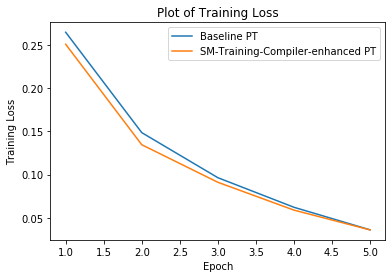

**Note:** For this example, due to the larger batch size that can be accommodated by the SageMaker Training Compiler, the initial decrease in training loss is greater when the SageMaker Training Compiler is enabled

### Evaluation

In [ ]:
# Create table of summary results including loss, accuracy, f1 score, precision, recall, and steps per second
# for both native and optimized training jobs

table = pd.DataFrame(
    [native_summary["eval"][-1], optimized_summary["eval"][-1]],
    index=["Baseline PT", "SM-Training-Compiler-enhanced PT"],
)
table.drop(columns=["eval_runtime", "eval_samples_per_second", "epoch"])

## Clean up

Stop all training jobs launched if the jobs are still running.

In [ ]:
import boto3

sm = boto3.client("sagemaker")


def stop_training_job(name):
    status = sm.describe_training_job(TrainingJobName=name)["TrainingJobStatus"]
    if status == "InProgress":
        sm.stop_training_job(TrainingJobName=name)


stop_training_job(native_estimator.latest_training_job.name)
stop_training_job(sm_training_compiler_estimator.latest_training_job.name)

Also, to find instructions on cleaning up resources, see [Clean Up](https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-cleanup.html) in the *Amazon SageMaker Developer Guide*.